# Импорт необходимых библиотек

In [2]:
import textwrap
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from numbers import Integral
from collections import Counter
from pathlib import Path
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.base import BaseSampler
from sklearn import set_config
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils._param_validation import Interval
from sklearn.utils import check_random_state

sns.set_theme(style="whitegrid", palette="dark", context="notebook")
set_config(transform_output="default")

# Подготовка данных

## Загрузка данных и проверка удовлетворения требованиям

In [3]:
base_dir = Path.cwd()
data_dir = base_dir / "data"
model_dir = base_dir / "model"

df = pd.read_csv(data_dir / "train.csv")

df.head()


customer_id              Name  age gender  \
0      fffe4300490044003600300030003800   Pattie Morrisey   18      F   
1  fffe43004900440032003100300035003700       Traci Peery   32      F   
2      fffe4300490044003100390032003600   Merideth Mcmeen   44      F   
3  fffe43004900440036003000330031003600  Eufemia Cardwell   37      M   
4  fffe43004900440031003900350030003600      Meghan Kosak   31      F   

  security_no region_category  membership_category joining_date  \
0     XW0DQ7H         Village  Platinum Membership   2017-08-17   
1     5K0N3X1            City   Premium Membership   2017-08-28   
2     1F2TCL3            Town        No Membership   2016-11-11   
3     VJGJ33N            City        No Membership   2016-10-29   
4     SVZXCWB            City        No Membership   2017-09-12   

  joined_through_referral referral_id  ... avg_time_spent  \
0                      No    xxxxxxxx  ...         300.63   
1                       ?    CID21329  ...         306.34   
2                     Yes    CID12313  ...         516.16   
3                     Yes     CID3793  ...          53.27   
4                      No    xxxxxxxx  ...         113.13   

  avg_transaction_value avg_frequency_login_days points_in_wallet  \
0              53005.25                     17.0           781.75   
1              12838.38                     10.0              NaN   
2              21027.00                     22.0           500.69   
3              25239.56                      6.0           567.66   
4              24483.66                     16.0           663.06   

   used_special_discount  offer_application_preference  past_complaint  \
0                    Yes                           Yes              No   
1                    Yes                            No             Yes   
2                     No                           Yes             Yes   
3                     No                           Yes             Yes   
4                     No                           Yes             Yes   

      complaint_status                  feedback churn_risk_score  
0       Not Applicable  Products always in Stock                2  
1               Solved     Quality Customer Care                1  
2  Solved in Follow-up              Poor Website                5  
3             Unsolved              Poor Website                5  
4               Solved              Poor Website                5  

[5 rows x 25 columns]

### Размер и структура

In [4]:
sh = df.shape

print("Количество записей:", sh[0])
print("Количество признаков:", sh[1] - 1)


Количество записей: 36992
Количество признаков: 24


In [5]:
print("Типы данных признаков")
df.dtypes


Типы данных признаков


customer_id                      object
Name                             object
age                               int64
gender                           object
security_no                      object
region_category                  object
membership_category              object
joining_date                     object
joined_through_referral          object
referral_id                      object
preferred_offer_types            object
medium_of_operation              object
internet_option                  object
last_visit_time                  object
days_since_last_login             int64
avg_time_spent                  float64
avg_transaction_value           float64
avg_frequency_login_days         object
points_in_wallet                float64
used_special_discount            object
offer_application_preference     object
past_complaint                   object
complaint_status                 object
feedback                         object
churn_risk_score                  int64


In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [7]:
print("Статистическое описание числовых признаков")
df.describe()


Статистическое описание числовых признаков


age  days_since_last_login  avg_time_spent  \
count  36992.000000           36992.000000    36992.000000   
mean      37.118161             -41.915576      243.472334   
std       15.867412             228.819900      398.289149   
min       10.000000            -999.000000    -2814.109110   
25%       23.000000               8.000000       60.102500   
50%       37.000000              12.000000      161.765000   
75%       51.000000              16.000000      356.515000   
max       64.000000              26.000000     3235.578521   

       avg_transaction_value  points_in_wallet  churn_risk_score  
count           36992.000000      33549.000000      36992.000000  
mean            29271.194003        686.882199          3.463397  
std             19444.806226        194.063624          1.409661  
min               800.460000       -760.661236         -1.000000  
25%             14177.540000        616.150000          3.000000  
50%             27554.485000        697.620000          4.000000  
75%             40855.110000        763.950000          5.000000  
max             99914.050000       2069.069761          5.000000

### Количество классов

In [8]:
unique_classes = df['churn_risk_score'].unique()
print("Количество уникальных классов в целевом признаке:", len(unique_classes))
print("Уникальные классы в целевом признаке:", unique_classes)


Количество уникальных классов в целевом признаке: 6
Уникальные классы в целевом признаке: [ 2  1  5  3  4 -1]


### Количество пропусков

In [9]:
def missing_entry():
    num_rows_with_nan = df.isnull().any(axis=1).sum()
    print("Количество записей с пропусками:", num_rows_with_nan)
    print(f"Процент записей с пропусками: {(num_rows_with_nan / sh[0]) * 100:.2f}%")
    print("\nКоличество пропусков в каждом столбце:")
    print(df.isnull().sum())

missing_entry()


Количество записей с пропусками: 8619
Процент записей с пропусками: 23.30%

Количество пропусков в каждом столбце:
customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                          

### Сбалансированность классов

In [10]:
class_counts = df['churn_risk_score'].value_counts()
print(class_counts)


churn_risk_score
 3    10424
 4    10185
 5     9827
 2     2741
 1     2652
-1     1163
Name: count, dtype: int64


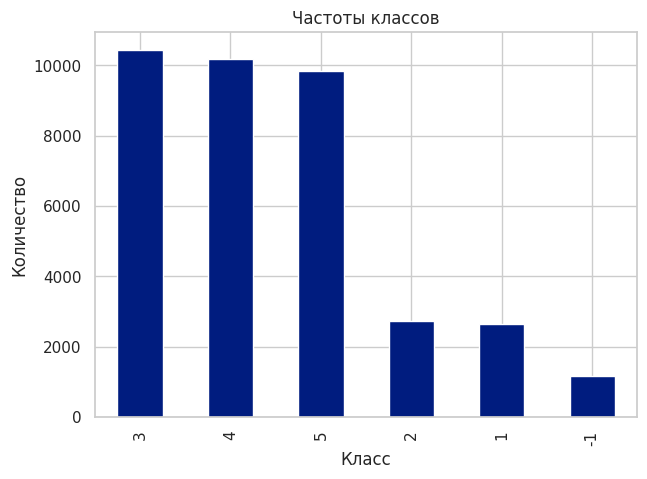

In [11]:
def plot_class_counts(df):
    if isinstance(df, pd.Series):
        class_counts = df.value_counts()
    elif isinstance(df, pd.DataFrame):
        class_counts = df['churn_risk_score'].value_counts()

    plt.figure(figsize=(7,5))
    class_counts.plot(kind='bar')
    plt.title('Частоты классов')
    plt.xlabel('Класс')
    plt.ylabel('Количество')
    plt.show()

plot_class_counts(df)


Данные удовлетворяют требованиям

## Отчистка данных

### Признак `referral_id`
`referral_id` принимает значение 8-значного кода, при отсутствии значения используется placeholder 'xxxxxxxx'.

Датасет не говорит что точно значит этот признак. Было предположено, что это реферальный код по которому человек зарегестрировался (а не его личный реферальный код).

Предположение было сделано из того, что не существут записей, где `joined_through_referral` принимал бы значение `No` и при этом `referral_id` не принимал бы значение placeholder'а.

In [12]:
df[(df['joined_through_referral'] == 'No') & (df['referral_id'] != 'xxxxxxxx')]


Empty DataFrame
Columns: [customer_id, Name, age, gender, security_no, region_category, membership_category, joining_date, joined_through_referral, referral_id, preferred_offer_types, medium_of_operation, internet_option, last_visit_time, days_since_last_login, avg_time_spent, avg_transaction_value, avg_frequency_login_days, points_in_wallet, used_special_discount, offer_application_preference, past_complaint, complaint_status, feedback, churn_risk_score]
Index: []

[0 rows x 25 columns]

Однако, существуют записи где `joined_through_referral` = `?`, но реферальный код не пустой. Поэтому, было принято решения заменить `joined_through_referral` на `YES` во всех записях, где `joined_through_referral` = `?` и реферальный код не пустой.

In [13]:
df[(df['joined_through_referral'] == '?') & (df['referral_id'] != 'xxxxxxxx')].head()


customer_id                Name  age gender  \
1   fffe43004900440032003100300035003700         Traci Peery   32      F   
7       fffe4300490044003800300035003800      Herma Torgeson   42      M   
15  fffe43004900440035003100340033003400     Stephane Pullum   16      F   
28  fffe43004900440033003900390037003900    Torri Mendelsohn   61      F   
30  fffe43004900440032003700370033003400  Genoveva Harriston   17      F   

   security_no region_category membership_category joining_date  \
1      5K0N3X1            City  Premium Membership   2017-08-28   
7      4UJ1551             NaN       No Membership   2016-07-12   
15     YTBUOEE            Town    Basic Membership   2017-07-09   
28     QUU2V55         Village   Silver Membership   2017-05-14   
30     KX657II            City       No Membership   2015-11-25   

   joined_through_referral referral_id  ... avg_time_spent  \
1                        ?    CID21329  ...     306.340000   
7                        ?    CID56614  ...     429.110000   
15                       ?    CID35062  ...      30.140000   
28                       ?    CID29752  ...    -936.744818   
30                       ?    CID40054  ...     162.930000   

   avg_transaction_value avg_frequency_login_days points_in_wallet  \
1               12838.38                     10.0              NaN   
7               44554.82                     24.0       568.080000   
15              18792.31                      7.0       141.513201   
28              29156.10                     10.0       710.380000   
30              31100.95                     11.0       633.050000   

    used_special_discount  offer_application_preference  past_complaint  \
1                     Yes                            No             Yes   
7                      No                           Yes             Yes   
15                    Yes                            No             Yes   
28                    Yes                            No             Yes   
30                     No                           Yes             Yes   

            complaint_status               feedback churn_risk_score  
1                     Solved  Quality Customer Care                1  
7                   Unsolved   Poor Product Quality                5  
15                  Unsolved           Too many ads                5  
28  No Information Available    No reason specified                4  
30                    Solved           Too many ads                5  

[5 rows x 25 columns]

In [14]:
df.loc[(df['joined_through_referral'] == '?') & (df['referral_id'] != 'xxxxxxxx'), 'joined_through_referral'] = 'Yes'


In [15]:
df[(df['joined_through_referral'] == '?') & (df['referral_id'] != 'xxxxxxxx')].head()


Empty DataFrame
Columns: [customer_id, Name, age, gender, security_no, region_category, membership_category, joining_date, joined_through_referral, referral_id, preferred_offer_types, medium_of_operation, internet_option, last_visit_time, days_since_last_login, avg_time_spent, avg_transaction_value, avg_frequency_login_days, points_in_wallet, used_special_discount, offer_application_preference, past_complaint, complaint_status, feedback, churn_risk_score]
Index: []

[0 rows x 25 columns]

### Удаление не несущих информации признаков
Следующие признаки являются техническими и не несут обобщающей информации, поэтому было принято решение удалить их:
1. `customer_id` - уникальный идентификатор
2. `Name` - имя покупателя
3. `security_no` - уникальный идентификатор безопасности
4. `referral_id` - реферальный код по которому человек зарегестрировался
5. `last_visit_time` - бесполезен, шумный, поскольку отражает один момент, а не типичное поведение покупателя. Также имеется более информативный признак `days_since_last_login`, который похож по смыслу на `last_visit_time`, но менее шумный и может отражать типичное поведение покупателя.

In [16]:
df = df.drop(columns=['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time'])
print(df.shape)


(36992, 20)


In [17]:
df.head()


age gender region_category  membership_category joining_date  \
0   18      F         Village  Platinum Membership   2017-08-17   
1   32      F            City   Premium Membership   2017-08-28   
2   44      F            Town        No Membership   2016-11-11   
3   37      M            City        No Membership   2016-10-29   
4   31      F            City        No Membership   2017-09-12   

  joined_through_referral     preferred_offer_types medium_of_operation  \
0                      No     Gift Vouchers/Coupons                   ?   
1                     Yes     Gift Vouchers/Coupons             Desktop   
2                     Yes     Gift Vouchers/Coupons             Desktop   
3                     Yes     Gift Vouchers/Coupons             Desktop   
4                      No  Credit/Debit Card Offers          Smartphone   

  internet_option  days_since_last_login  avg_time_spent  \
0           Wi-Fi                     17          300.63   
1     Mobile_Data                     16          306.34   
2           Wi-Fi                     14          516.16   
3     Mobile_Data                     11           53.27   
4     Mobile_Data                     20          113.13   

   avg_transaction_value avg_frequency_login_days  points_in_wallet  \
0               53005.25                     17.0            781.75   
1               12838.38                     10.0               NaN   
2               21027.00                     22.0            500.69   
3               25239.56                      6.0            567.66   
4               24483.66                     16.0            663.06   

  used_special_discount offer_application_preference past_complaint  \
0                   Yes                          Yes             No   
1                   Yes                           No            Yes   
2                    No                          Yes            Yes   
3                    No                          Yes            Yes   
4                    No                          Yes            Yes   

      complaint_status                  feedback  churn_risk_score  
0       Not Applicable  Products always in Stock                 2  
1               Solved     Quality Customer Care                 1  
2  Solved in Follow-up              Poor Website                 5  
3             Unsolved              Poor Website                 5  
4               Solved              Poor Website                 5

### Удаление дубликатов

In [18]:
before = len(df)
df = df.drop_duplicates()
print(f"Удалено дубликатов: {before - len(df)}")


Удалено дубликатов: 0


### Удаление строк с отрицательным `churn_risk_score`

In [19]:
before = len(df)

df = df[df['churn_risk_score'] >= 0]

after = len(df)

print(f"Удалено строк с отрицательным `churn_risk_score`: {before - after}")


Удалено строк с отрицательным `churn_risk_score`: 1163


### Работа с признаками

In [20]:
missing_entry()


Количество записей с пропусками: 8357
Процент записей с пропусками: 22.59%

Количество пропусков в каждом столбце:
age                                0
gender                             0
region_category                 5263
membership_category                0
joining_date                       0
joined_through_referral            0
preferred_offer_types            276
medium_of_operation                0
internet_option                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3341
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64


In [21]:
df['joining_date'] = pd.to_datetime(df['joining_date'], errors='coerce')

print(f"Количество значений NaT: {df['joining_date'].isna().sum()}\n")

all_cols = df.columns.tolist()
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()

print(f"Все признаки: {all_cols}\n")
print(f"Категориальные признаки: {categorical_cols}\n")
print(f"Числовые признаки: {numeric_cols}\n")
print(f"Даты: {datetime_cols}\n")

def unique_values():
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print("Уникальные значения для категориальных признаков")
    for col in categorical_cols:
        unique = df[col].unique()
        print(f"{col}: {unique}")

unique_values()


Количество значений NaT: 0

Все признаки: ['age', 'gender', 'region_category', 'membership_category', 'joining_date', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score']

Категориальные признаки: ['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'avg_frequency_login_days', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']

Числовые признаки: ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'points_in_wallet', 'churn_risk_score']

Даты: ['joining_date']

Уникальные значения для категориальных признаков
gender: ['F' 'M' 'Unknown']

Заменим значения в признаках:
1. `gender` с `Unknown` на `nan`
2. `joined_through_referral` с `?` на `nan`
3. `medium_of_operation` с `?` на `nan`

In [22]:
df['gender'] = df['gender'].replace('Unknown', np.nan)
df['joined_through_referral'] = df['joined_through_referral'].replace('?', np.nan)
df['medium_of_operation'] = df['medium_of_operation'].replace('?', np.nan)


In [23]:
missing_entry()
print()
unique_values()


Количество записей с пропусками: 12727
Процент записей с пропусками: 34.40%

Количество пропусков в каждом столбце:
age                                0
gender                            56
region_category                 5263
membership_category                0
joining_date                       0
joined_through_referral          547
preferred_offer_types            276
medium_of_operation             5230
internet_option                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3341
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Уникальные значения для категориальных признаков
gender: ['F' 'M' nan]
region_category: ['Village' 'City' 'Town' nan]
membership_c

### Удаление пропусков, признаков, обработка грязных данных
1. Поскольку количестов записей с отсутствием `gender` небольшой, было принято решение удалить их.
2. Записей с отсутствием в признаке `region_category` много. Неизвестно в каком домене компания предоставляет услуги, поэтому затруднительно определить насколько признак релевантен. Было принято решение исходить из того, что отток не зависит от этого признака, поэтому признак удаляется. Однако для реальной задачи, возможно, имело бы смысл обучить модель без этого признака и с ним по отдельности, заменив пропуски, например, значением `Unknown`, или модой (если есть предпосылки для этого).
3. Отсутствующие записи в `joined_through_referral` было решено заменить на `Unknown`, поскольку это семмантически корректно, мы просто не знаем был ли пользователь приглашен.
4. Отсутствующие записи в `preferred_offer_types` было решено заменить на `Unknown`, поскольку это семмантически корректно, мы просто не знаем предпочтение пользователя.
5. Было решено удалить признаки `medium_of_operation`, `internet_option`. Это решение было принято из-за того, что скорее всего причинная зависимость между оттоком и устройством пользователя/его типом интернет соединения отсутствует. Возможные различия между пользователями этих категорий вероятно случайны или вызваны внешними факторами, например, техническими ограничениями, а не поведением клиента, связанным с сервисом.
6. Из датасета неочевидно, пропуски в `points_in_wallet` признаке представлены в качестве события "Клиент не учавствует в программе лояльности", или "У клиента есть кошелек, но данные просто пропущены", или "У клиента 0 баллов". Было принято решение исходить из 2 варианта, поэтому пропуски были заполнены медианой.

In [24]:
df = df.drop(columns=['region_category', 'medium_of_operation', 'internet_option'])
print(df.shape)


(35829, 17)


In [25]:
df = df[df['gender'].notna()]
print(df.shape)


(35773, 17)


In [26]:
df['joined_through_referral'] = df['joined_through_referral'].fillna('Unknown')
df['preferred_offer_types'] = df['preferred_offer_types'].fillna('Unknown')


Признак `points_in_wallet` будет заполнен немного позже, после разделения данных, чтобы не создать data leakage.

Перед этим необходимо разобраться с признаком `avg_frequency_login_days`, поскольку он явно содержит отрицательные значения и пропуски. А также с признаками `days_since_last_login`, `avg_time_spent`, `points_in_wallet`, которые содержат отрицательные значения.

In [27]:
df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')

df['avg_frequency_login_days'].isna().sum()


np.int64(3416)

In [28]:
missing_entry()


Количество записей с пропусками: 6431
Процент записей с пропусками: 17.38%

Количество пропусков в каждом столбце:
age                                0
gender                             0
membership_category                0
joining_date                       0
joined_through_referral            0
preferred_offer_types              0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3416
points_in_wallet                3332
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64


In [29]:
afld_neg_count = (df['avg_frequency_login_days'] < 0).sum()
afld_pos_count = (df['avg_frequency_login_days'] > 0).sum()

print(f"Отрицательных значений в avg_frequency_login_days: {afld_neg_count}")
print(f"Положительных значений в avg_frequency_login_days: {afld_pos_count}\n")

dsll_neg_count = (df['days_since_last_login'] < 0).sum()
dsll_pos_count = (df['days_since_last_login'] > 0).sum()

print(f"Отрицательных значений в days_since_last_login: {dsll_neg_count}")
print(f"Положительных значений в days_since_last_login: {dsll_pos_count}\n")

ats_neg_count = (df['avg_time_spent'] < 0).sum()
ats_pos_count = (df['avg_time_spent'] > 0).sum()

print(f"Отрицательных значений в avg_time_spent: {ats_neg_count}")
print(f"Положительных значений в avg_time_spent: {ats_pos_count}\n")

piw_neg_count = (df['points_in_wallet'] < 0).sum()
piw_pos_count = (df['points_in_wallet'] > 0).sum()

print(f"Отрицательных значений в points_in_wallet: {piw_neg_count}")
print(f"Положительных значений в points_in_wallet: {piw_pos_count}\n")


Отрицательных значений в avg_frequency_login_days: 656
Положительных значений в avg_frequency_login_days: 31701

Отрицательных значений в days_since_last_login: 1938
Положительных значений в days_since_last_login: 33835

Отрицательных значений в avg_time_spent: 1656
Положительных значений в avg_time_spent: 34117

Отрицательных значений в points_in_wallet: 134
Положительных значений в points_in_wallet: 32307



Датасет не говорит что именно значит признак `avg_frequency_login_days`, но было предположено из названия, что это средняя частота логинов в днях. За какой промежуток - неизвестно, возможно за неделю, или за месяц. Но это не принципиально. Из этого определения следует, что признак `avg_frequency_login_days` не может принимать отрицательные значения. Было принято решение удалить все строки, содержащие отрицательные значения, поскольку это грязные данные. Пропуски было принято решение заменить медианой.

Также удалим все вышеуказанные отрицательные значения по тем-же причинам

In [30]:
df = df[(df['avg_frequency_login_days'] >= 0) | (df['avg_frequency_login_days'].isna())]

df = df[(df['days_since_last_login'] >= 0) | (df['days_since_last_login'].isna())]
df = df[(df['avg_time_spent'] >= 0) | (df['avg_time_spent'].isna())]
df = df[(df['points_in_wallet'] >= 0) | (df['points_in_wallet'].isna())]

deleted = sh[0] - len(df)

print(f"Количество удаленных строк всего: {deleted}")
print(f"Процент удаленных строк: {deleted/sh[0] * 100}%")


Количество удаленных строк всего: 5419
Процент удаленных строк: 14.649113321799309%


К сожалению, пришлось удалить около 15% датасета из-за загрязненности данных.

In [31]:
missing_entry()
print()
unique_values()


Количество записей с пропусками: 5740
Процент записей с пропусками: 15.52%

Количество пропусков в каждом столбце:
age                                0
gender                             0
membership_category                0
joining_date                       0
joined_through_referral            0
preferred_offer_types              0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3059
points_in_wallet                2976
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

Уникальные значения для категориальных признаков
gender: ['F' 'M']
membership_category: ['Platinum Membership' 'Premium Membership' 'No Membership'
 'Gold Membership' 'Silver Membership' 'Basic Membership']
joined_through_referral: ['No' 'Yes

In [32]:
df.shape


(31573, 17)

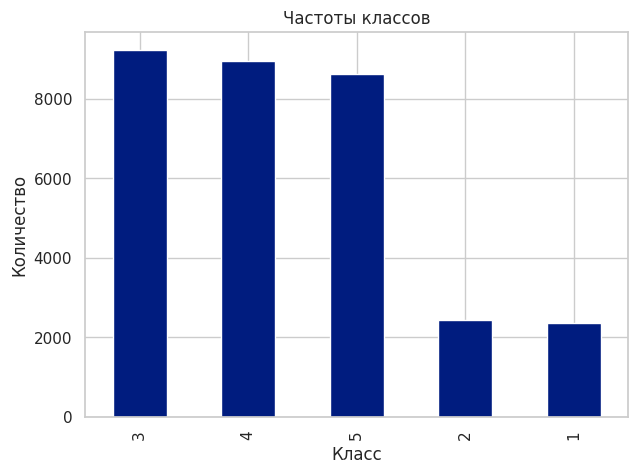

In [33]:
plot_class_counts(df)


Осталось заполнить пропуски для `avg_frequency_login_days ` и `points_in_wallet` медианным значением. Но перед этим обязательно нужно сделать разделение train/test. Иначе будет data leakage.

Перед разделением выполним преобразование над признаком `joining_date` в `joining_days`

In [34]:
epoch = pd.Timestamp('2000-01-01')

df['joining_days'] = (df['joining_date'] - epoch).dt.days
df = df.drop(columns=['joining_date'])


In [35]:
missing_entry()
print()
unique_values()


Количество записей с пропусками: 5740
Процент записей с пропусками: 15.52%

Количество пропусков в каждом столбце:
age                                0
gender                             0
membership_category                0
joined_through_referral            0
preferred_offer_types              0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days        3059
points_in_wallet                2976
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
joining_days                       0
dtype: int64

Уникальные значения для категориальных признаков
gender: ['F' 'M']
membership_category: ['Platinum Membership' 'Premium Membership' 'No Membership'
 'Gold Membership' 'Silver Membership' 'Basic Membership']
joined_through_referral: ['No' 'Yes

## Анализ данных

### Разделение на train/test

Разделим данные на train/test, а также создадим копию train для анализа данных, для удаления выбросов и построения графиков.

Чтобы избежать data leakage, не будем производить заполнение пропусков на всем `X_train`. Эти шаги будут выполняться в pipeline и выполнены внутри кросс-валидации. Иначе, при кросс-валидации информация из валидационных фолдов будет неявно учавствовать в вычислении статистик для обучении, что приведек к завышенным метрикам.

Для предварительного анализа и детекции выбросов создается отдельная копия данных `X_analysis`, которая не будет использоваться для обучения модели.

In [36]:
X = df.drop(columns=['churn_risk_score'])
y = df['churn_risk_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_analysis = X_train.copy()

nan_cols = ['avg_frequency_login_days', 'points_in_wallet']

for col in nan_cols:
    med = X_analysis[col].median()
    X_analysis[col] = X_analysis[col].fillna(med)


### Определение выбросов

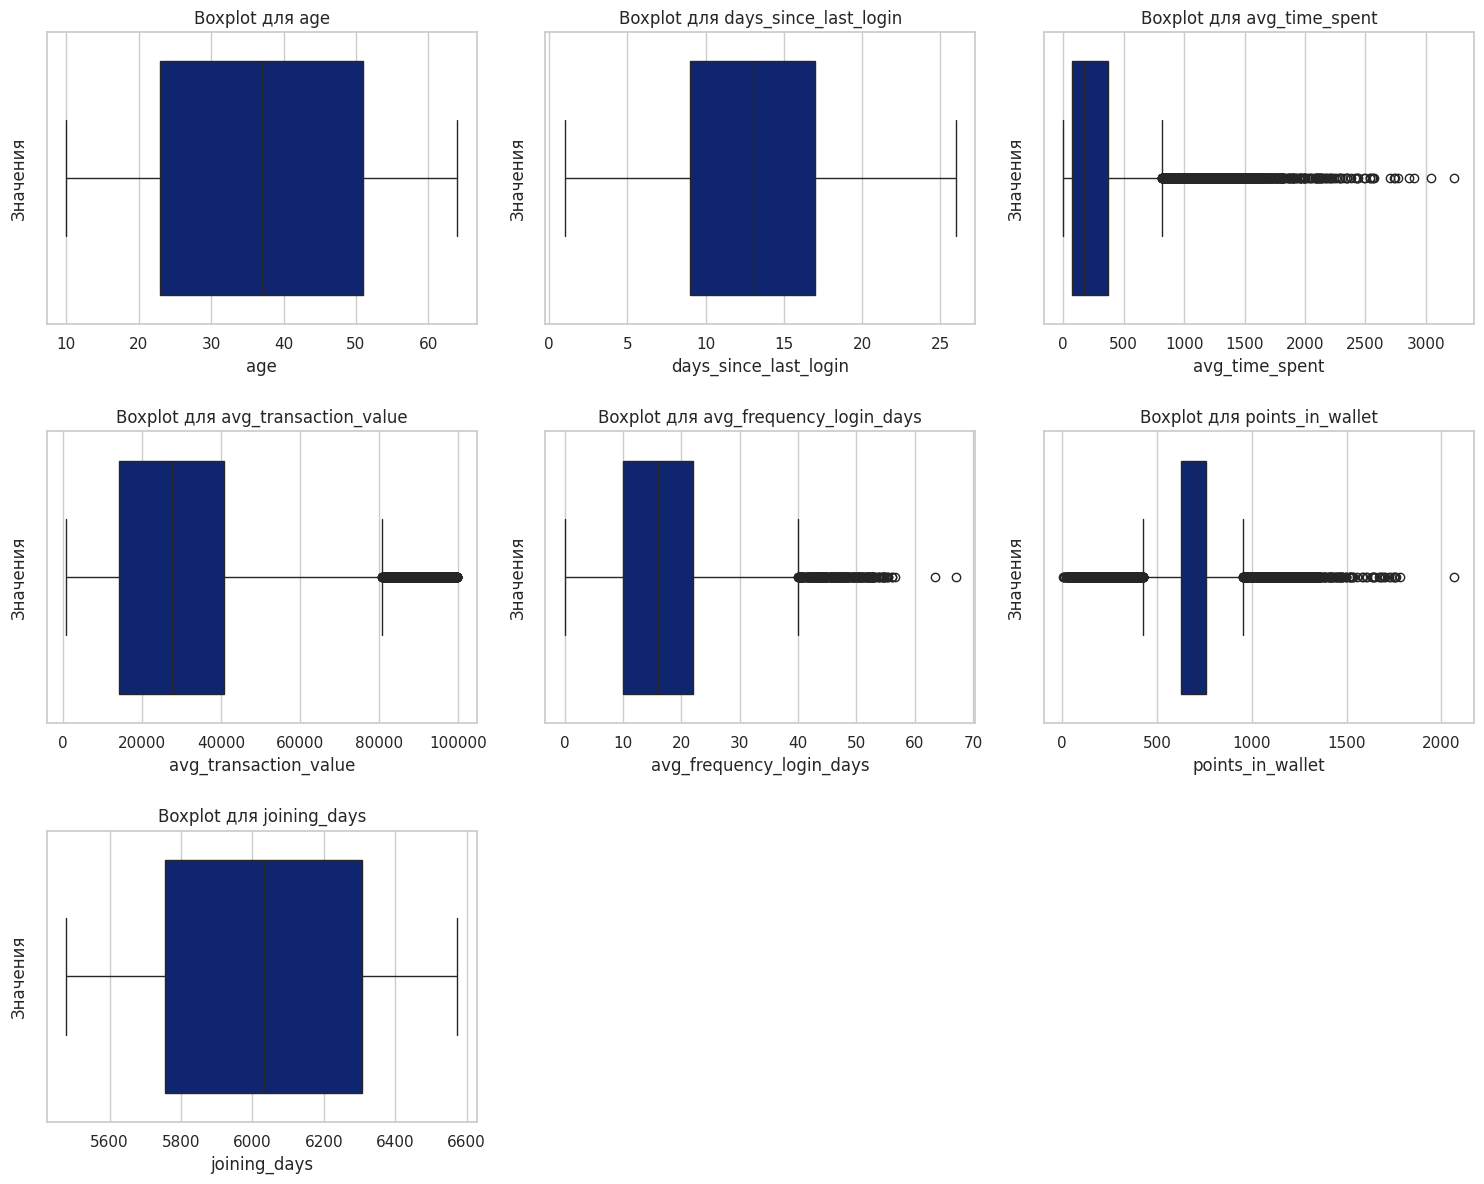

In [37]:
numeric_features = ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value','avg_frequency_login_days', 'points_in_wallet', 'joining_days']


def plot_boxplots(df, cols, fig_cols=3):
    fig_rows = int(np.ceil(len(cols) / fig_cols))

    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*5, fig_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.boxplot(x=df[col], ax=axes[i])
        title = f"Boxplot для {col}"
        wrapped = "\n".join(textwrap.wrap(title, width=40))
        axes[i].set_title(wrapped)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Значения')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(h_pad=2.0)
    plt.show()

plot_boxplots(X_analysis, numeric_features, 3)


Наблюдаются выбросы в `avg_time_spent`, `avg_frequency_login_days`, `points_in_wallet` удалим их по правилу IQR.

In [38]:
iters = 15

sh_before = X_train.shape
removed_sum = 0

X_dropoutliers = X_train.copy()

for col in numeric_features:
    X_dropoutliers[col] = X_dropoutliers[col].fillna(X_dropoutliers[col].median())

for i in range(iters):
    num_features = X_dropoutliers[numeric_features]

    Q1 = num_features.quantile(0.25)
    Q3 = num_features.quantile(0.75)
    IQR = Q3 - Q1

    outliers_mask = ((num_features < (Q1 - 1.5 * IQR)) | (num_features > (Q3 + 1.5 * IQR)))
    rows_to_drop = outliers_mask.any(axis=1)

    removed = rows_to_drop.sum()
    removed_sum += removed

    print(f"Итерация {i+1}: Удалено выбросов: {removed}")

    if removed == 0:
        break

    idx_to_drop = X_dropoutliers.index[rows_to_drop]
    
    X_dropoutliers = X_dropoutliers.drop(idx_to_drop)
    X_train = X_train.drop(idx_to_drop)
    y_train = y_train.drop(idx_to_drop)

print(f"До: {sh_before} После {X_train.shape}")
print(f"Всего удалено выбросов: {removed_sum}")




Итерация 1: Удалено выбросов: 5906
Итерация 2: Удалено выбросов: 1045
Итерация 3: Удалено выбросов: 355
Итерация 4: Удалено выбросов: 168
Итерация 5: Удалено выбросов: 65
Итерация 6: Удалено выбросов: 33
Итерация 7: Удалено выбросов: 9
Итерация 8: Удалено выбросов: 3
Итерация 9: Удалено выбросов: 0
До: (25258, 16) После (17674, 16)
Всего удалено выбросов: 7584


### Boxplot после удаления выбросов

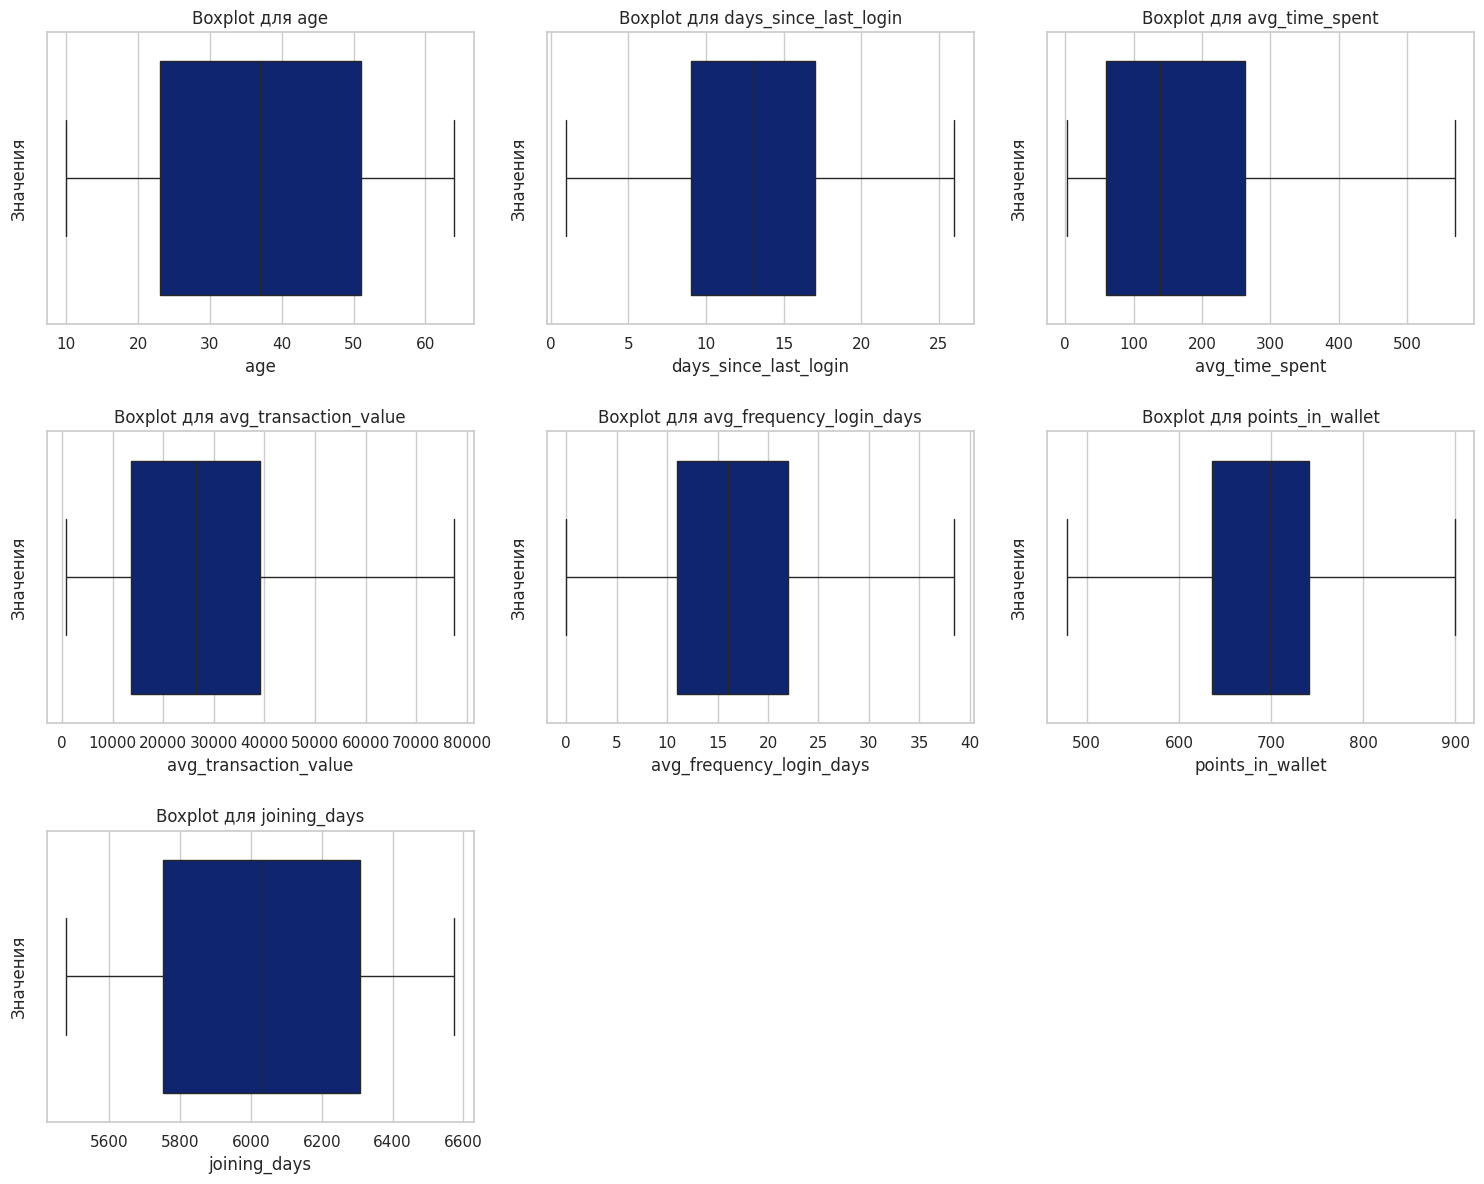

In [39]:
plot_boxplots(X_dropoutliers, numeric_features, 3)


### Построение гистограмм признаков

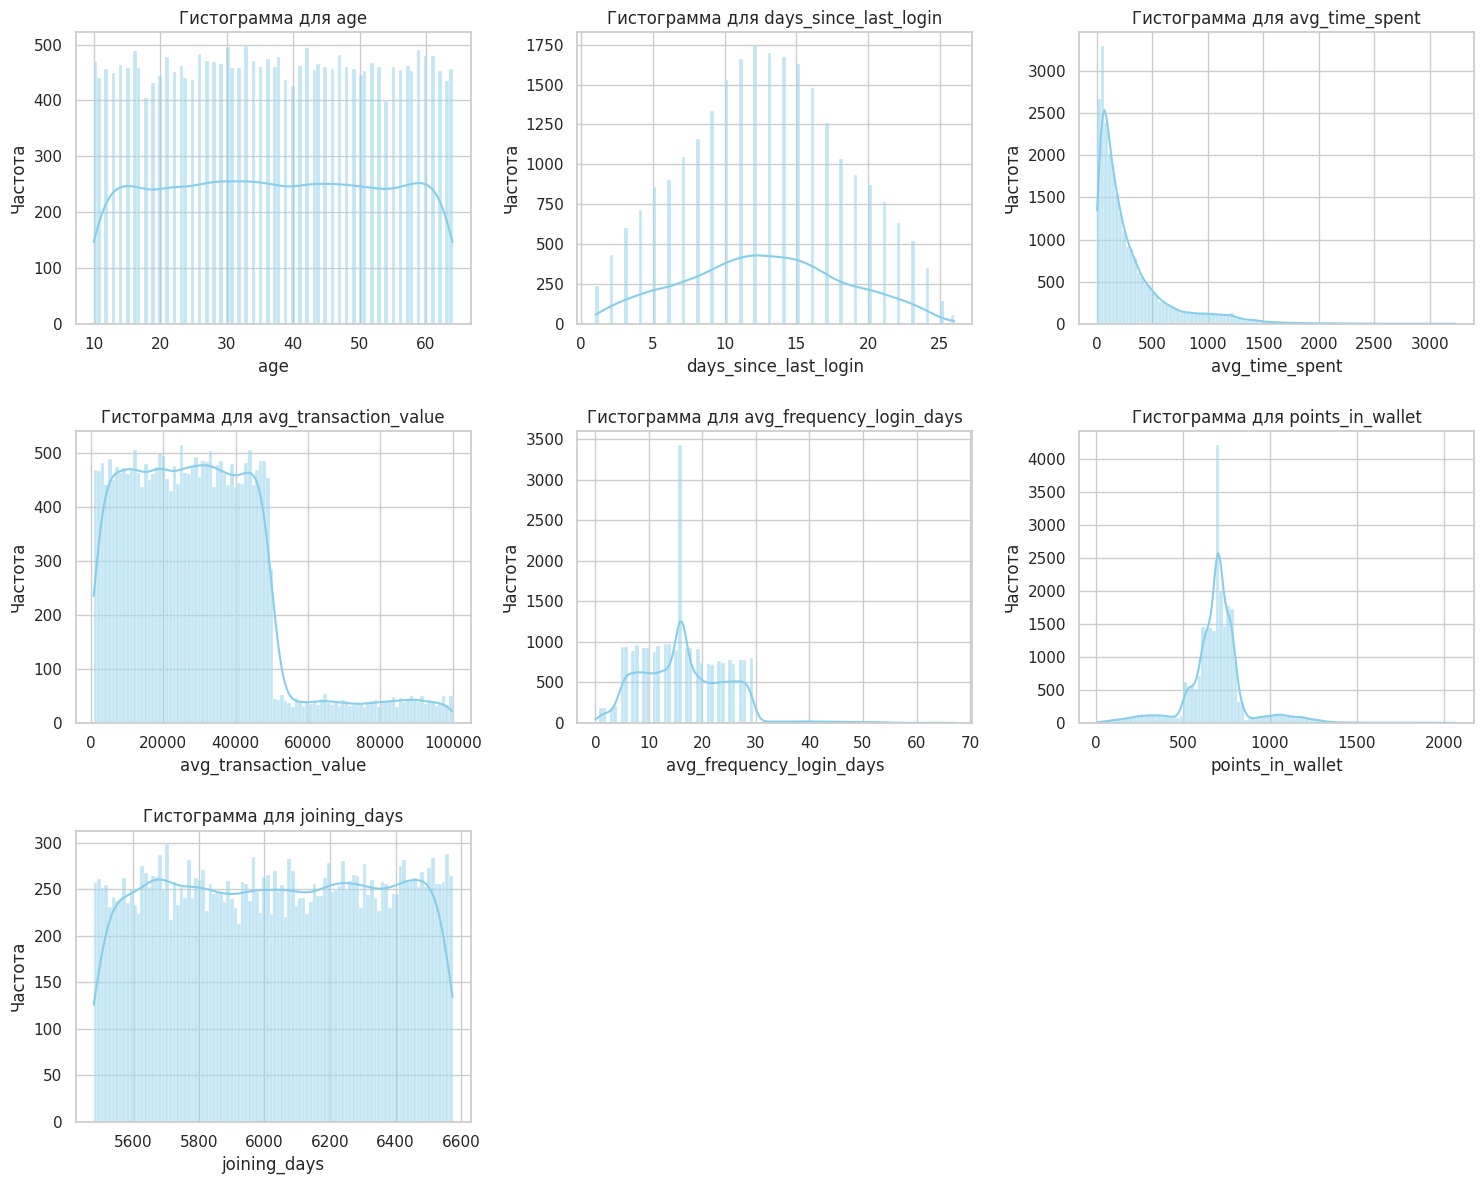

In [40]:
def plot_histograms(df, cols, fig_cols=3):
    fig_rows = int(np.ceil(len(cols) / fig_cols))

    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(fig_cols*5, fig_rows*4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=100)
        title = f"Гистограмма для {col}"
        wrapped = "\n".join(textwrap.wrap(title, width=40))
        axes[i].set_title(wrapped)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Частота')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(h_pad=2.0)
    plt.show()

plot_histograms(X_analysis, numeric_features, 3)


### Тепловая карта корреляций

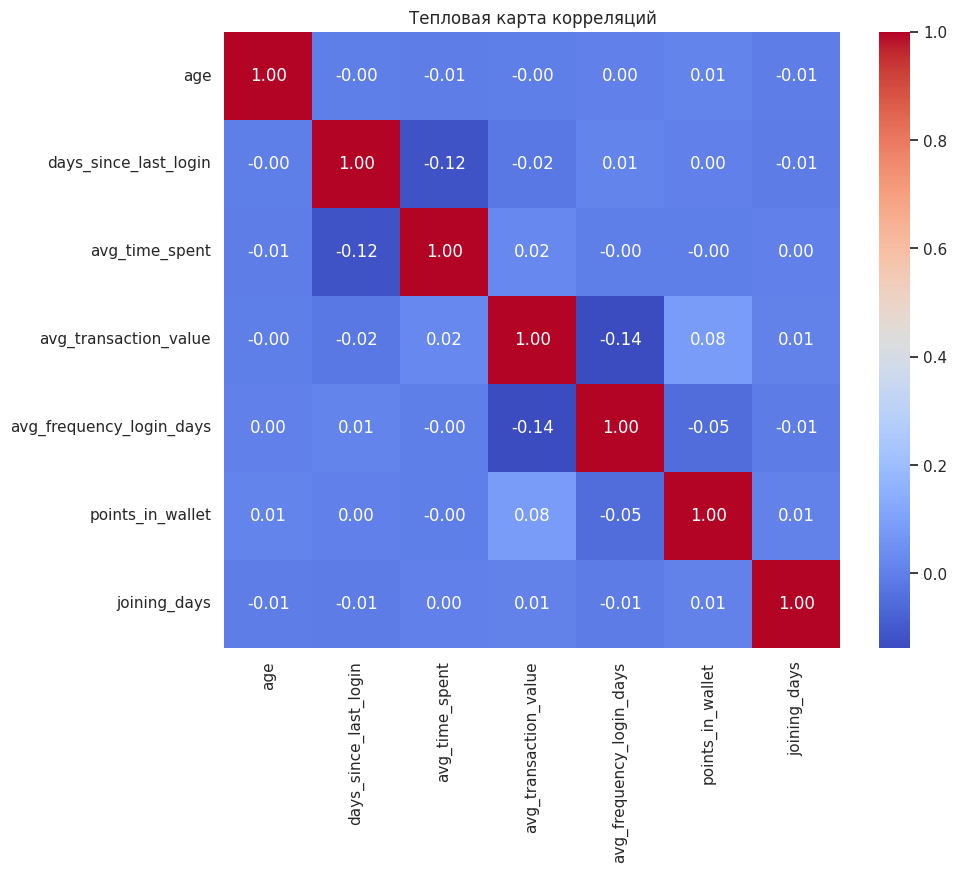

In [41]:
def plot_heatmap(df):
    num_features = df[numeric_features]
    corr = num_features.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Тепловая карта корреляций')
    plt.show()

plot_heatmap(X_analysis)


Большой корреляции (> 0.8) не обнаружено

### Построение диаграмм рассеяния

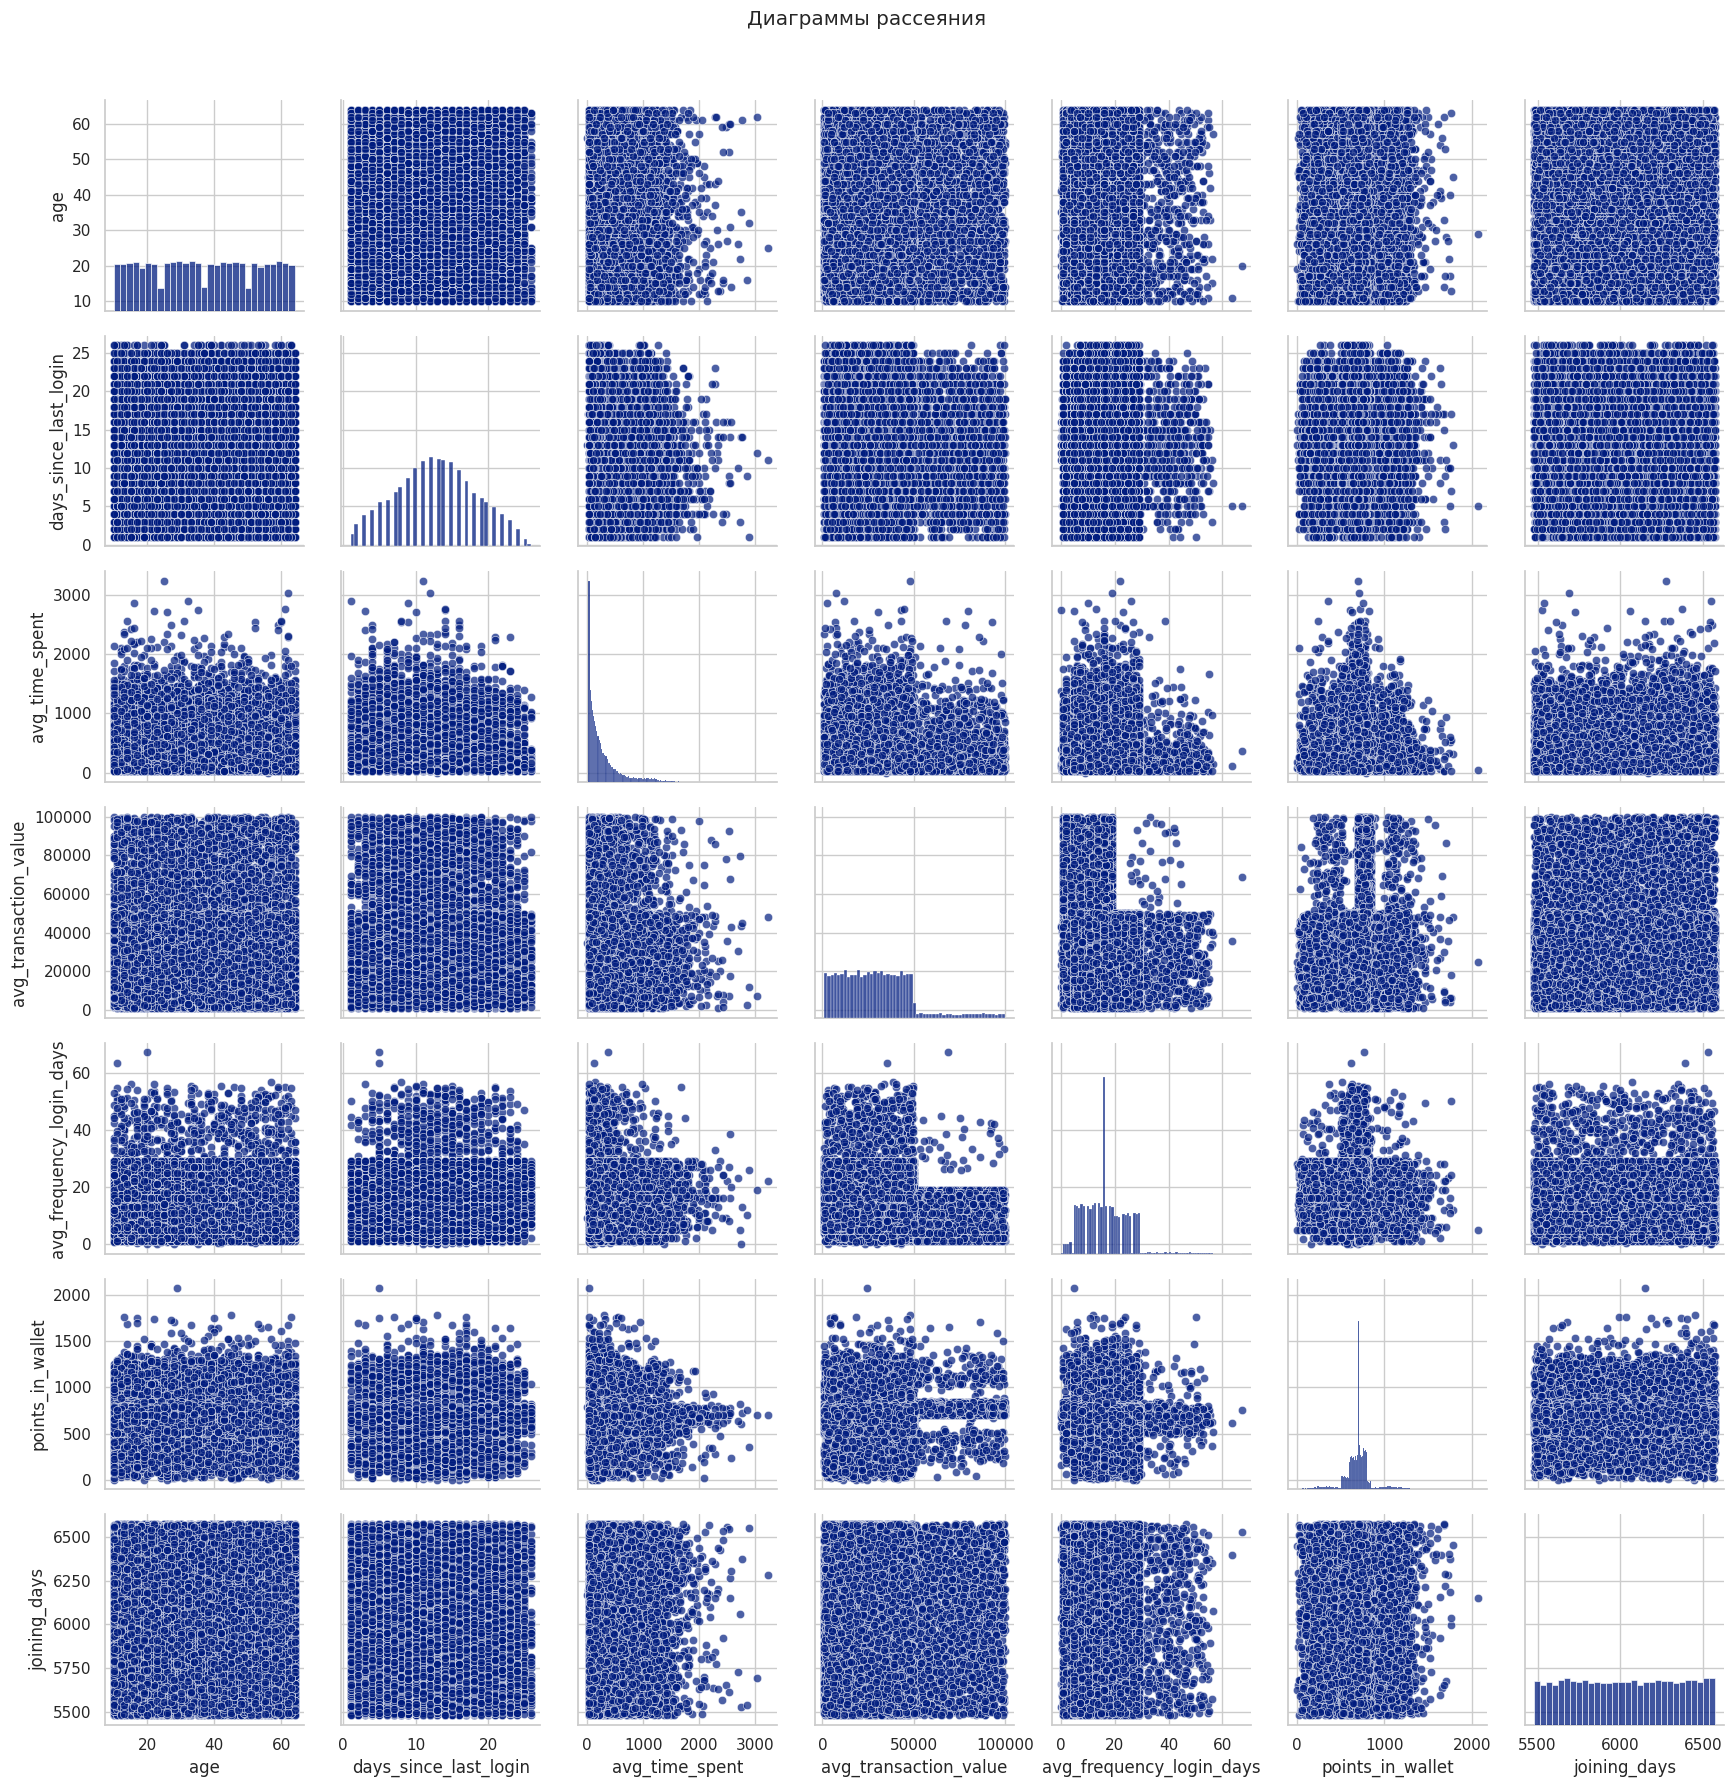

In [42]:
def plot_pairplots(df):
    num_features = df[numeric_features]
    sns.pairplot(num_features, plot_kws={'alpha':0.7})
    plt.suptitle('Диаграммы рассеяния', y=1.02)
    plt.tight_layout()
    plt.show()

plot_pairplots(X_analysis)


## Подготовка pipelin'а для обучения

### Кастомный класс для балансировки
SMOTENC - кастомный класс, написанный для балансировки и совместимостью с pipilen'ом

In [43]:
class MY_SMOTENC(BaseSampler):

    _parameter_constraints = {
        "categorical_features": ["array-like"],
        "k_neighbors": [Interval(Integral, 1, None, closed="left")],
        "random_state": ["random_state"],
    }

    _sampling_type = 'over-sampling'

    def __init__(self, categorical_features, k_neighbors=5, random_state=None):
        super().__init__()
        self.categorical_features = categorical_features
        self.k_neighbors = k_neighbors
        self.random_state = random_state

    def _fit_resample(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        rng = check_random_state(self.random_state)

        n_samples, n_features = X.shape

        # булевы маски для категориальных и числовых признаков
        cat_idx = np.array(self.categorical_features, dtype=int)
        cat_mask = np.zeros(n_features, dtype=bool)
        cat_mask[cat_idx] = True
        cont_mask = ~cat_mask

        # итоговые исходные + синтетические данные
        X_resampled = [X]
        y_resampled = [y]

        # подсчитываем кол-во объектов в каждом классе
        classes, class_counts = np.unique(y, return_counts=True)
        max_count = class_counts.max()

        for cls, count in zip(classes, class_counts):
            if count == max_count:
                continue

            class_indices = np.flatnonzero(y == cls)

            # объекты текущего класса
            X_class = X[class_indices]

            n_class = X_class.shape[0]

            # количество объектов для генерации
            n_new = max_count - n_class

            if n_new <= 0:
                continue

            if n_class == 1:
                # если в классе только один объект, просто повторяем его
                X_new = np.repeat(X_class, n_new, axis=0)
                y_new = np.full(n_new, cls, dtype=y.dtype)
                X_resampled.append(X_new)
                y_resampled.append(y_new)
                continue
            
            # разделяем на числовые и категориальные признаки
            X_class_cont = X_class[:, cont_mask] if cont_mask.any() else None
            X_class_cat = X_class[:, cat_mask] if cat_mask.any() else None

            if X_class_cont is not None and X_class_cont.shape[1] > 0:
                nn_data = X_class_cont
                metric = "euclidean"
            else:
                nn_data = X_class_cat
                metric = "hamming"

            k_neighbors = min(self.k_neighbors, n_class - 1)
            neigh = NearestNeighbors(n_neighbors=k_neighbors + 1, metric=metric, n_jobs=-1)
            neigh.fit(nn_data)

            # находим k ближайших соседей для каждого объекта класса (1-й сосед всегда сам объект)
            _, neighbor_indices = neigh.kneighbors(nn_data)

            synthetic_samples = []

            for _ in range(n_new):
                # выбираем случайный объект класса
                idx = rng.randint(0, n_class)
                x_i = X_class[idx]

                # выбираем случайного соседа этого объекта
                neighbor_ids = neighbor_indices[idx, 1:]
                nn_idx = rng.choice(neighbor_ids)
                x_nn = X_class[nn_idx]

                x_new = x_i.copy()

                if cont_mask.any():
                    lam = rng.rand()

                    # генерируем новый пример между x_i и x_nn по формуле x_new = x_i + λ * (x_nn - x_i)
                    x_new[cont_mask] = (
                        x_i[cont_mask] + lam * (x_nn[cont_mask] - x_i[cont_mask])
                    )

                if cat_mask.any():
                    # берем категориальные признаки двух точек
                    cats_i = x_i[cat_mask]
                    cats_nn = x_nn[cat_mask]

                    # для каждого категориального признака создаем маску выбора значения: False (0) - из x_i, True (1) - из x_nn
                    choose_from_nn = rng.rand(cats_i.shape[0]) < 0.5
                    cats_new = np.where(choose_from_nn, cats_nn, cats_i)

                    # подставляем полученные категориальные признаки в новый пример
                    x_new[cat_mask] = cats_new

                synthetic_samples.append(x_new)

            X_new = np.vstack(synthetic_samples)
            y_new = np.full(n_new, cls, dtype=y.dtype)

            X_resampled.append(X_new)
            y_resampled.append(y_new)

        X_res = np.vstack(X_resampled)
        y_res = np.concatenate(y_resampled)

        return X_res, y_res

### Создание препроцессоров для пайплайнов

In [44]:
numeric_features = ['age', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value','avg_frequency_login_days', 'points_in_wallet', 'joining_days']
categorical_features = ['gender', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']

num_cols_count = len(numeric_features)
cat_cols_count = len(categorical_features)
num_indices = list(range(num_cols_count))
cat_indices = list(range(num_cols_count, num_cols_count + cat_cols_count))

preprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),

        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ],
    verbose_feature_names_out=False
)

preprocessor_tree= ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ],
    verbose_feature_names_out=False
)

postprocessor_linear = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_indices),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_indices)
    ],
    verbose_feature_names_out=False
)

### Сборка пайплайна

In [45]:
pipeline_knn = Pipeline([
    ('initial_prep', preprocessor_linear),
    ('balancer', MY_SMOTENC(categorical_features=cat_indices, random_state=42)),
    ('postprocessor', postprocessor_linear),
    ('clf', KNeighborsClassifier())
])

pipeline_svm = Pipeline([
    ('initial_prep', preprocessor_linear),
    ('balancer', MY_SMOTENC(categorical_features=cat_indices, random_state=42)),
    ('postprocessor', postprocessor_linear),
    ('clf', SVC(probability=False))
])

pipeline_rf = Pipeline([
    ('initial_prep', preprocessor_tree),
    ('balancer', MY_SMOTENC(categorical_features=cat_indices, random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Обучение

## KNN

### Подбор гиперпараметров

In [46]:
param_grid_knn = {
    'clf__n_neighbors': range(1, 20),
    'clf__p': [1, 2],
    'clf__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

print("Лучшие параметры:", grid_knn.best_params_)
print("Лучший f1_macro:", grid_knn.best_score_)

knn_model = grid_knn.best_estimator_

Fitting 5 folds for each of 76 candidates, totalling 380 fits


Лучшие параметры: {'clf__n_neighbors': 19, 'clf__p': 1, 'clf__weights': 'distance'}
Лучший f1_macro: 0.6744946700087623


In [528]:
knn_model = joblib.load(model_dir / 'knn_model.pkl')

### Оценка качества модели

KNN accuracy: 0.6774346793349169
KNN F1      : 0.6497158359358395
KNN ROC-AUC : 0.9190208434082037

Classification Report:
               precision    recall  f1-score   support

           1     0.5485    0.6964    0.6137       471
           2     0.6066    0.5289    0.5651       484
           3     0.8316    0.7577    0.7930      1845
           4     0.6183    0.5184    0.5640      1790
           5     0.6474    0.7930    0.7129      1725

    accuracy                         0.6774      6315
   macro avg     0.6505    0.6589    0.6497      6315
weighted avg     0.6825    0.6774    0.6753      6315



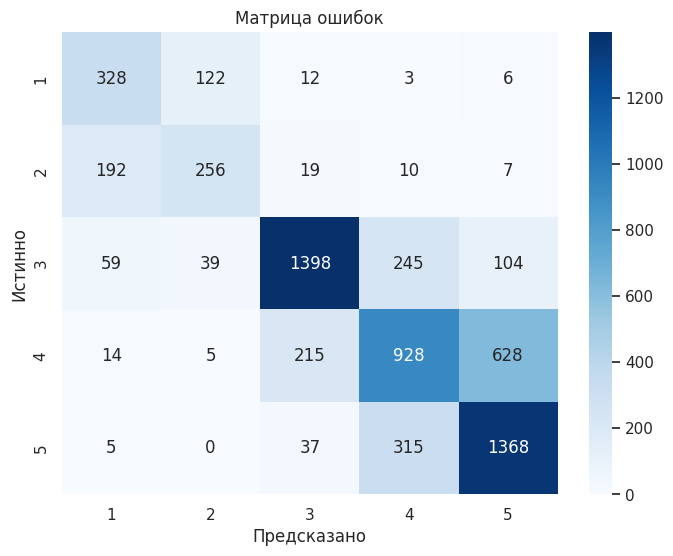

In [48]:
pred_knn = knn_model.predict(X_test)
proba_knn = knn_model.predict_proba(X_test)

print('KNN accuracy:', accuracy_score(y_test, pred_knn))
print('KNN F1      :', f1_score(y_test, pred_knn, average='macro'))

# One versus rest ROC-AUC
# 1) Задача разбивается на N (5) бинарных задач. Для каждого i-го класса считается свой локальный AUC_class_{i}, где целевым классом является i-й класс, а остальные классы объединяются в один "остальные".
#   a) Составляем все возможные пары (y_test == i, y_test != i)
#   b) Считаем в скольких парах y_test == i имеет большую вероятность, чем y_test != i (пусть это число S)
#   c) Вычисляем AUC_class_{i} = S / (число всех пар)
# 2) Общий AUC вычисляется как среднее значение по всем AUC_class_{i}

print('KNN ROC-AUC :', roc_auc_score(y_test, proba_knn, multi_class='ovr'))

print('\nClassification Report:\n', classification_report(y_test, pred_knn, digits=4))

cm = confusion_matrix(y_test, pred_knn)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)

plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()

## SVM

### Подбор гиперпараметров

Мы не оптимизируем гиперараметры по метрике, которая использует вероятность. Поэтому, с целью ускорения, поиск гиперпараметров происходит на SVM без дополнительного этапа калибровки вероятностней. Далее, чтобы оценить ROC-AUC, обучим модель на полученных лучших параметрах

In [142]:
param_grid_svm = [
    {
        'clf__kernel': ['linear'],
        'clf__C': [0.05, 0.1, 0.15, 1],
    },
    {
        'clf__kernel': ['rbf'],
        'clf__C': [0.05, 0.1, 0.15, 1],
        'clf__gamma': ['scale', 0.001, 0.01, 0.1],
    },
    {
        'clf__kernel': ['sigmoid'],
        'clf__C': [0.05, 0.1, 0.15, 1],
        'clf__gamma': ['scale', 0.001, 0.01, 0.1],
        'clf__coef0': [0.0, 0.1, 0.5],
    }
]


grid_svm = GridSearchCV(
    pipeline_svm, 
    param_grid_svm, 
    cv=3,
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

grid_svm.fit(X_train, y_train)

svm_best_params = grid_svm.best_params_

print("Лучшие параметры:", svm_best_params)
print("Лучший f1_macro:", grid_svm.best_score_)

Fitting 3 folds for each of 68 candidates, totalling 204 fits
Лучшие параметры: {'clf__C': 1, 'clf__coef0': 0.5, 'clf__gamma': 0.01, 'clf__kernel': 'sigmoid'}
Лучший f1_macro: 0.7643173416479515


In [143]:
svm_model = clone(pipeline_svm)

svm_model.set_params(**svm_best_params)

svm_model.set_params(
    clf__probability=True,
    clf__random_state=42
)

svm_model.fit(X_train, y_train);

In [49]:
svm_model = joblib.load(model_dir / 'svm_model.pkl')

### Оценка качества модели

SVM accuracy: 0.7201900237529691
SVM F1      : 0.6982632232194388
SVM ROC-AUC : 0.9220744950032183

Classification Report:
               precision    recall  f1-score   support

           1     0.6826    0.7261    0.7037       471
           2     0.6765    0.6653    0.6708       484
           3     0.8094    0.8721    0.8396      1845
           4     0.7383    0.3972    0.5165      1790
           5     0.6552    0.9067    0.7607      1725

    accuracy                         0.7202      6315
   macro avg     0.7124    0.7135    0.6983      6315
weighted avg     0.7275    0.7202    0.7034      6315



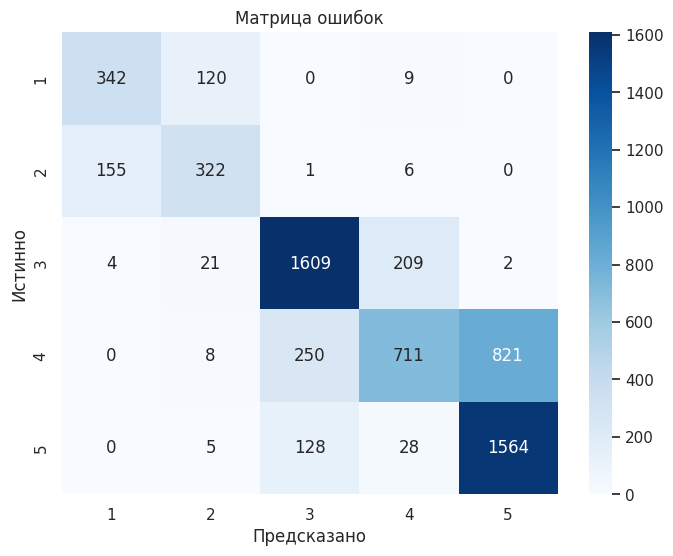

In [144]:
pred_svm = svm_model.predict(X_test)
proba_svm = svm_model.predict_proba(X_test)

print('SVM accuracy:', accuracy_score(y_test, pred_svm))
print('SVM F1      :', f1_score(y_test, pred_svm, average='macro'))
print('SVM ROC-AUC :', roc_auc_score(y_test, proba_svm, multi_class='ovr'))

print('\nClassification Report:\n', classification_report(y_test, pred_svm, digits=4))

cm = confusion_matrix(y_test, pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)

plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()

## Random Forest

### Подбор гиперпараметров

In [145]:
param_grid_rf = {
    'clf__n_estimators': [200, 300, 350],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 7],
    'clf__max_features': ['log2', 'sqrt']
}

grid_rf = GridSearchCV(
    pipeline_rf, 
    param_grid_rf, 
    cv=3,
    scoring='f1_macro', 
    n_jobs=-1, 
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Лучшие параметры:", grid_rf.best_params_)
print("Лучший f1_macro:", grid_rf.best_score_)

rf_model = grid_rf.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Лучшие параметры: {'clf__max_depth': 20, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Лучший f1_macro: 0.7813652179093235


In [49]:
rf_model = joblib.load(model_dir / 'rf_model.pkl')

### Оценка качества модели

RF accuracy: 0.7689627870150435
RF F1      : 0.7545364912911767
RF ROC-AUC : 0.960001664853892

Classification Report:
               precision    recall  f1-score   support

           1     0.7129    0.7537    0.7327       471
           2     0.7537    0.7273    0.7403       484
           3     0.8940    0.9144    0.9041      1845
           4     0.7299    0.5436    0.6231      1790
           5     0.6991    0.8632    0.7725      1725

    accuracy                         0.7690      6315
   macro avg     0.7579    0.7604    0.7545      6315
weighted avg     0.7700    0.7690    0.7632      6315



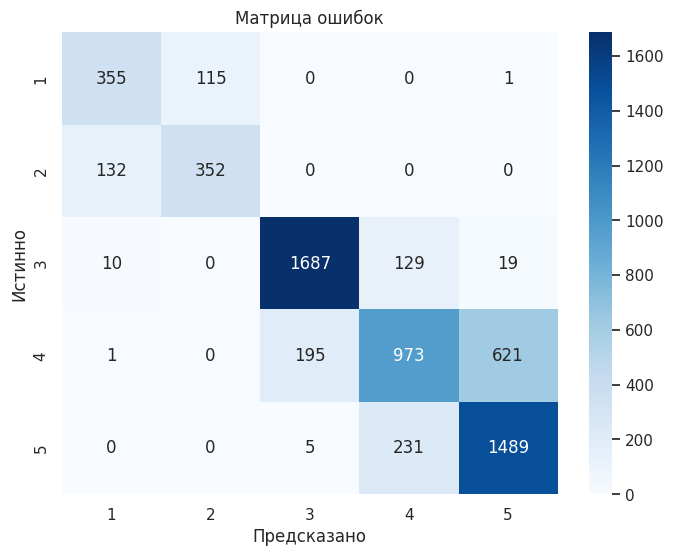

In [50]:
pred_rf = rf_model.predict(X_test)
proba_rf = rf_model.predict_proba(X_test)

print('RF accuracy:', accuracy_score(y_test, pred_rf))
print('RF F1      :', f1_score(y_test, pred_rf, average='macro'))
print('RF ROC-AUC :', roc_auc_score(y_test, proba_rf, multi_class='ovr'))

print('\nClassification Report:\n', classification_report(y_test, pred_rf, digits=4))

cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()

Построение графика feature importance

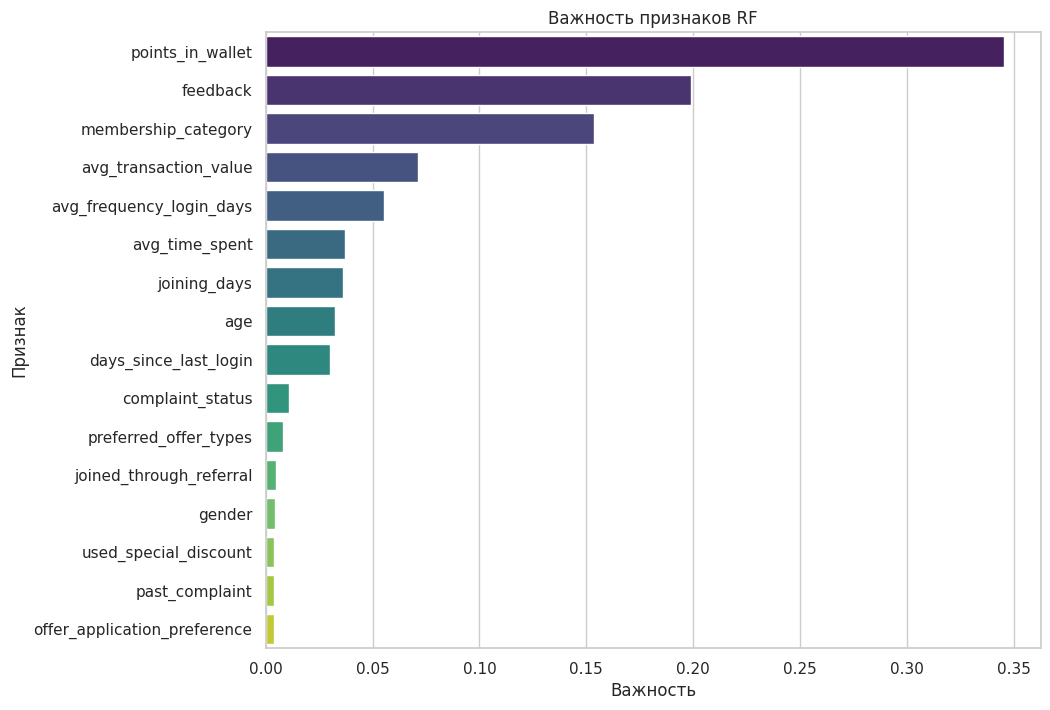

In [150]:
feature_names = numeric_features + categorical_features
importances = rf_model.named_steps['clf'].feature_importances_

df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

df_importances = df_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=df_importances, 
    x='importance', 
    y='feature',
    palette='viridis',
    hue='feature'
)

plt.title('Важность признаков RF', fontsize=12)
plt.xlabel('Важность', fontsize=12)
plt.ylabel('Признак', fontsize=12)
plt.show()

## Сохранение моделей

In [147]:
joblib.dump(knn_model, model_dir / 'knn_model.pkl');
joblib.dump(svm_model, model_dir / 'svm_model.pkl');
joblib.dump(rf_model, model_dir / 'rf_model.pkl');